In [93]:
'''
COMPSCI 760 Group Project :Extending NCP to supervised learning - power dataset 
Found at https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
Original NCP repo :https://github.com/mlech26l/keras-ncp
Original LTC repo :https://github.com/raminmh/liquid_time_constant_networks
'''

'\nCOMPSCI 760 Group Project :Extending NCP to supervised learning - power dataset \nFound at https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption\nOriginal NCP repo :https://github.com/mlech26l/keras-ncp\nOriginal LTC repo :https://github.com/raminmh/liquid_time_constant_networks\n'

In [94]:
import pandas
import numpy as np
import tensorflow as tf
from tensorflow import keras
import kerasncp
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import scipy.stats

## Data preprocessing - same as ltc

In [95]:
def convert_to_floats(feature_col,memory):
    for i in range(len(feature_col)):
        if(feature_col[i]=="?" or feature_col[i] == "\n"):
            feature_col[i] = memory[i]
        else:
            feature_col[i] = float(feature_col[i])
            memory[i] = feature_col[i]
    return feature_col,memory

def load_crappy_formated_csv():

    all_x = []    
    with open("./data/household_power_consumption.txt","r") as f:
        lineno = -1
        memory = [i for i in range(7)]
        for line in f:
            lineno += 1
            if(lineno == 0):
                continue
            arr = line.split(";")
            if(len(arr)<8):
                continue
            feature_col = arr[2:]
            feature_col,memory = convert_to_floats(feature_col,memory)
            all_x.append(np.array(feature_col,dtype=np.float32))

    all_x = np.stack(all_x,axis=0)
    all_x -= np.mean(all_x,axis=0) #normalize
    all_x /= np.std(all_x,axis=0) #normalize

    all_y = all_x[:,0].reshape([-1,1])
    all_x = all_x[:,1:]


    return all_x,all_y


def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)      

In [90]:
x,y = load_crappy_formated_csv()
        
train_x,train_y = cut_in_sequences(x,y,32,inc=32)

print("train_x.shape:",str(train_x.shape))
print("train_y.shape:",str(train_y.shape))


total_seqs = train_x.shape[1]
print("Total number of training sequences: {}".format(total_seqs))
permutation = np.random.RandomState(23489).permutation(total_seqs)
valid_size = int(0.1*total_seqs)
test_size = int(0.15*total_seqs)

valid_x = train_x[:,permutation[:valid_size]]
valid_y = train_y[:,permutation[:valid_size]]
test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
train_x = train_x[:,permutation[valid_size+test_size:]]
train_y = train_y[:,permutation[valid_size+test_size:]]

train_x.shape: (32, 64851, 6)
train_y.shape: (32, 64851, 1)
Total number of training sequences: 64851


### Plot the pdf of target variable - traffic_volume

In [82]:
# to plot the prob density of the target variable
yy = []
out = np.empty(y.shape[0], dtype=object)
y_list = y.tolist()
for i in tqdm(range(len(y))):
    yy.append(y_list[i][0])
out[:] = yy

100%|██████████| 2075259/2075259 [00:01<00:00, 1535261.09it/s]


<AxesSubplot:ylabel='Density'>

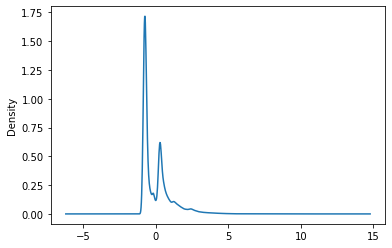

In [83]:
pandas.Series(out).plot.kde()

## Experiments on randomly connected NCP

In [98]:
neurons = [3,6,8]

# higher sparsity is likely to cause overfitting
sparsity = [0.2,0.3,0.4]

# epochs
epochs_n = 20

# batch size
batch_size_n = 16

# random seeds
random_seeds = [1111,1112,1113,1114,1115]

# a dict that stores all test loss, key = random_seed
all_test_loss_dic = {}

In [ ]:
# Experiment with hyparameters - number of neurons, sparsity, random seeds
for r in random_seeds:
    all_test_loss_dic[r] = []
    for i in neurons:
        for j in sparsity: 
            print(str(i)+' neurons,'+' '+str(j)+' sparsity,'+' '+'random seed = '+str(r))
            arch = kerasncp.wirings.Random(i, 1, sparsity_level=j, random_seed = r)
            rnn_cell = LTCCell(arch)
            model = tf.keras.models.Sequential(
                [
                    tf.keras.Input((None, 6)),
                    tf.keras.layers.RNN(rnn_cell, return_sequences=True),
                ]
            )
            model.compile(
                optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
            )

            traffic_ncp_history = model.fit(x=train_x, y=train_y, batch_size=batch_size_n, epochs=epochs_n, validation_data=(valid_x,valid_y))
            test_loss = round(model.evaluate(test_x,test_y, batch_size_n),4)
            all_test_loss_dic[r].append(test_loss)
            loss_train = traffic_ncp_history.history['loss']
            loss_val = traffic_ncp_history.history['val_loss']
            epochs = range(1,epochs_n+1)
            plt.plot(epochs, loss_train, 'g', label='Training loss')
            plt.plot(epochs, loss_val, 'b', label='validation loss')
            plt.title('Training and Validation MSE loss ')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            #plt.show()
            filename = 'rd'+str(r)+'_'+str(i)+'_'+str(j)[0]+str(j)[2]
            plt.savefig('power_img/'+filename)
            plt.pause(1)

3 neurons, 0.2 sparsity, random seed = 1111
Epoch 1/20


## Experiments on NCP topology

#### For graphs, please refer to the power_img folder

In [ ]:
# interneurons and command neurons for iteractions
param = [2,3,5]

for r in itertools.product(param, param):
    print('Inter neurons:',r[0],'command neurons',r[1])
    arch = kerasncp.wirings.NCP(
    inter_neurons=r[0],  # Number of inter neurons
    command_neurons=r[1],  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=2,  # How many incoming synapses has each motor neuron
)
    rnn_cell = LTCCell(arch)
    model = tf.keras.models.Sequential(
            [
                tf.keras.Input((None, 6)),
                tf.keras.layers.RNN(rnn_cell, return_sequences=True),
            ]
        )
    model.compile(
            optimizer=tf.keras.optimizers.Adam(0.01,epsilon=1e-08), loss=tf.keras.losses.MeanSquaredError()
        )
    traffic_ncp_history = model.fit(x=train_x, y=train_y, batch_size=batch_size_n, epochs=epochs_n, validation_data=(valid_x,valid_y))
    test_loss = round(model.evaluate(test_x,test_y, batch_size_n),4)
    #all_test_loss.append(str(i)+'_'+str(j)[0]+str(j)[2]+':'+str(test_loss))
    loss_train = traffic_ncp_history.history['loss']
    loss_val = traffic_ncp_history.history['val_loss']
    epochs = range(1,epochs_n+1)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation MSE loss ')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()